In [2]:
#import nilearn as ni
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn import plotting
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [ ]:
# Fetch data using nilearn dataset fetcher
haxby_dataset = datasets.fetch_haxby()

# Classifying representations of different visual stimuli

In [ ]:
# load labels
df = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

stimuli = df['labels']
print(stimuli.unique())

# identify resting state labels in order to be able to remove them
#task_mask = (stimuli !='rest')
task_mask = stimuli.isin(['face', 'house', 'cat'])

# extract tags indicating to which acquisition run a tag belongs
session_labels = df['chunks'][task_mask]

In [ ]:
# For decoding, standardizing is often very important
mask_filename = haxby_dataset.mask_vt[0]
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                 cmap='autumn')


In [ ]:
masker = NiftiMasker(mask_img=mask_filename, standardize=True)
func_filename = haxby_dataset.func[0]
masked_timecourses = masker.fit_transform(
    func_filename)[task_mask]

In [ ]:
# Define classifiers

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

svm = SVC(C=100., kernel="linear")
logistic = LogisticRegression(C=1., penalty="l2", solver='liblinear')
random_forest = RandomForestClassifier(n_estimators=10)

# Cross-validated versions of these classifiers

svm_cv = GridSearchCV(SVC(C=1., kernel="linear"),
                      param_grid={'C': [.1, 1., 10., 100.], 'kernel': ['linear', 'rbf']},
                      scoring='accuracy', n_jobs=1, cv=3, iid=False)

logistic_cv = GridSearchCV(
        LogisticRegression(C=1., penalty="l2", solver='liblinear'),
        param_grid={'C': [.1, 1., 10., 100.]},
        scoring='accuracy', cv=3, iid=False,
        )


# A dictionary, to hold all our classifiers
classifiers = {'SVC': svm,
               #'SVC cv': svm_cv,
               'log': logistic,
               #'log cv': logistic_cv,
               'random_forest': random_forest,
               }

In [ ]:
# predict scores for all classifiers

# Make a data splitting object for cross validation
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
cv = LeaveOneGroupOut()

import time

classifiers_scores = {}

for classifier_name, classifier in sorted(classifiers.items()):
    classifiers_scores[classifier_name] = {}
    print(70 * '_')

    for category in categories:
        classification_target = stimuli[task_mask].isin([category])
        t0 = time.time()
        classifiers_scores[classifier_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="accuracy",
        )

        print(
            "%10s: %14s -- scores: %1.2f +- %1.2f, time %.2fs" %
            (
                classifier_name,
                category,
                classifiers_scores[classifier_name][category].mean(),
                classifiers_scores[classifier_name][category].std(),
                time.time() - t0,
            ),
        )

In [ ]:
classifiers_scores

In [ ]:
# make a bar plot

plt.figure(figsize=(8,6))

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, classifier_name in zip(['b', 'c', 'm'],sorted(classifiers)):
    score_means = [classifiers_scores[classifier_name][category].mean()
                   for category in categories]
    score_std = [np.std(classifiers_scores[classifier_name][category]) for category in categories]
    plt.bar(tick_position, score_means, label=classifier_name,
            width=.11, color=color, yerr=score_std)
    tick_position = tick_position + .12

plt.ylabel('Classification accuracy')
plt.xlabel('Stimuli category')
plt.ylim(ymin=0)
plt.legend(loc='best')
plt.title(
    'Category-specific classification accuracy for different classifiers')
plt.tight_layout()

In [ ]:
# plot face vs. house maps for different classifiers

# Use the average EPI as a background
from nilearn import image
mean_epi_img = image.mean_img(func_filename)

# Restrict the decoding to face vs house
condition_mask = stimuli.isin(['face', 'house'])
masked_timecourses = masked_timecourses[
    condition_mask[task_mask]]
stimuli = (stimuli[condition_mask] == 'face')
# Transform the stimuli to binary values
stimuli.astype(np.int)

from nilearn.plotting import plot_stat_map, show

for classifier_name, classifier in sorted(classifiers.items()):
    classifier.fit(masked_timecourses, stimuli)

    if hasattr(classifier, 'coef_'):
        weights = classifier.coef_[0]
    elif hasattr(classifier, 'best_estimator_'):
        weights = classifier.best_estimator_.coef_[0]
    else:
        continue
    weight_img = masker.inverse_transform(weights)
    weight_map = weight_img.get_data()
    threshold = np.max(np.abs(weight_map)) * 1e-3
    plot_stat_map(weight_img, bg_img=mean_epi_img,
                  display_mode='z', cut_coords=[-15],
                  threshold=threshold,
                  title='%s: face vs house' % classifier_name)

show()

# ICA in nilearn

In [3]:
adhd_dataset = datasets.fetch_adhd(n_subjects=20)
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

/Users/amandae/anaconda2/envs/rriML/lib/python3.7/site-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [4]:
# run ICA on the data

from nilearn.decomposition import CanICA

canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(func_filenames)

# Retrieve the independent components in brain space. Directly
# accesible through attribute `components_img_`. Note that this
# attribute is implemented from version 0.4.1. For older versions,
# see note section above for details.
components_img = canica.components_img_
# components_img is a Nifti Image object, and can be saved to a file with
# the following line:
components_img.to_filename('canica_resting_state.nii.gz')

[MultiNiftiMasker.fit] Loading data from [/Users/amandae/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /Users/amandae/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /Users/amandae/nilearn_
[MultiNiftiMasker.fit] Computing mask


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   43.3s finished


[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Users/amandae/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Users/amandae/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Users/amandae/nilearn_data/adhd/data/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[Multi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=209652396)
__________________________________________________________fastica - 4.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=398764591)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


__________________________________________________________fastica - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


__________________________________________________________fastica - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s


__________________________________________________________fastica - 3.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.7s remaining:    0.0s


__________________________________________________________fastica - 4.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s


__________________________________________________________fastica - 4.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.0s remaining:    0.0s


__________________________________________________________fastica - 1.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=1491434855)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   22.6s remaining:    0.0s


__________________________________________________________fastica - 3.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.3s remaining:    0.0s


__________________________________________________________fastica - 5.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.003215, ..., -0.000272],
       ...,
       [ 0.003617, ...,  0.004832]]), whiten=True, fun='cube', random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.4s remaining:    0.0s


__________________________________________________________fastica - 2.1s, 0.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.5s finished


/Users/amandae/anaconda2/envs/rriML/lib/python3.7/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/Users/amandae/anaconda2/envs/rriML/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


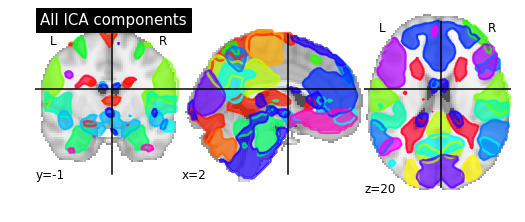

In [5]:
# plot all components in 1 figure

from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')

/Users/amandae/anaconda2/envs/rriML/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


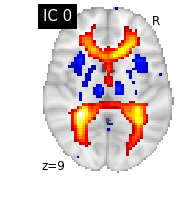

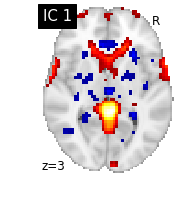

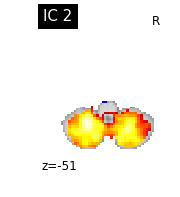

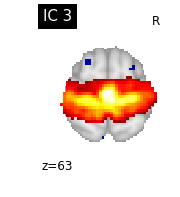

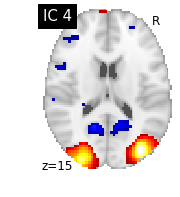

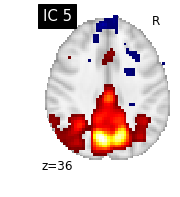

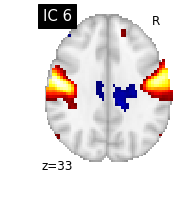

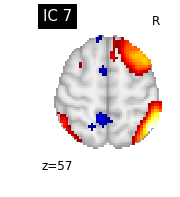

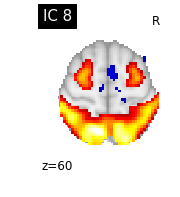

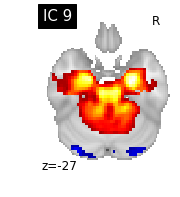

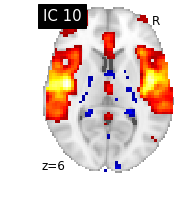

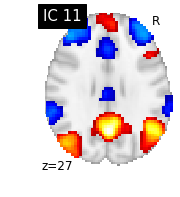

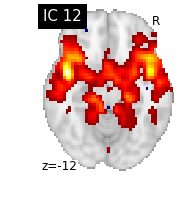

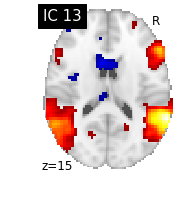

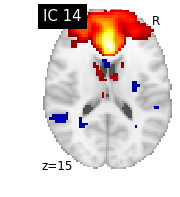

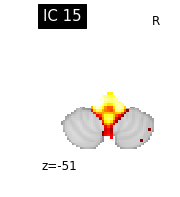

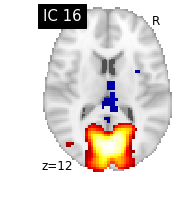

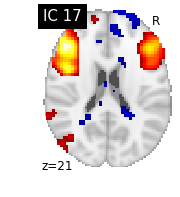

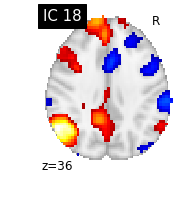

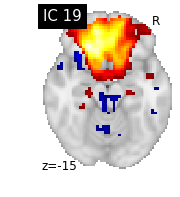

In [6]:
# plot each component separately

from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)

show()

In [7]:
components_img